In [1]:
pip install pandas numpy matplotlib seaborn plotly statsmodels sktime pmdarima tensorflow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       753 non-null    datetime64[ns]
 1   Open       753 non-null    float64       
 2   High       753 non-null    float64       
 3   Low        753 non-null    float64       
 4   Close      753 non-null    float64       
 5   Adj Close  753 non-null    float64       
 6   Volume     753 non-null    int64         
 7   Return     753 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 47.2 KB
None

Data Description:
                                Date        Open        High         Low  \
count                            753  753.000000  753.000000  753.000000   
mean   2022-07-01 22:30:07.171314688  254.154197  257.952244  250.760823   
min              2021-01-04 00:00:00   90.080000   90.460000   88.090000   
25%           

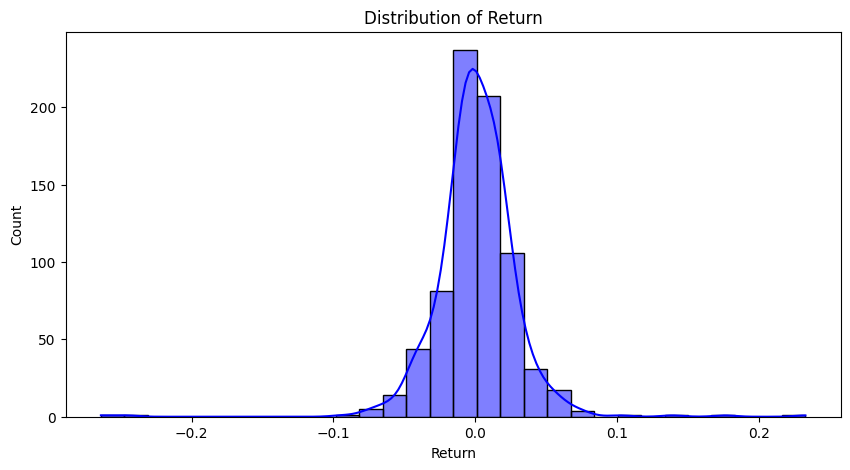

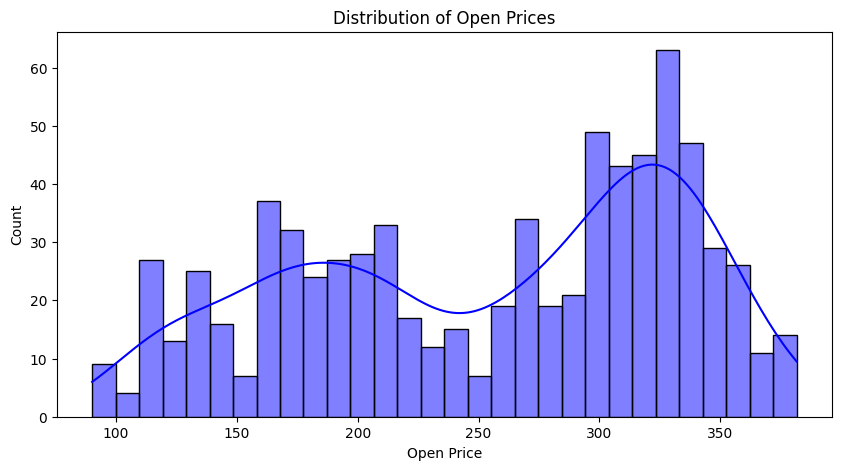

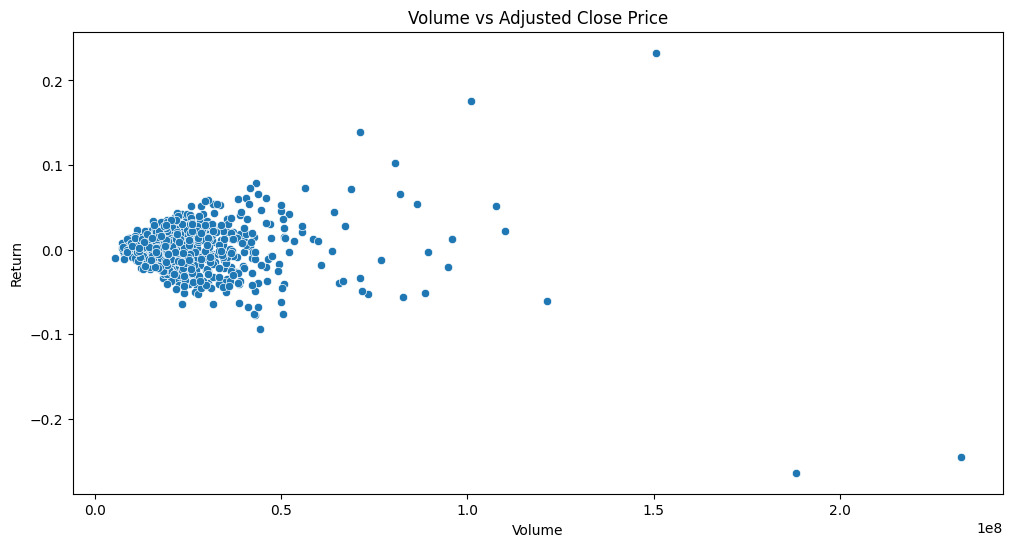

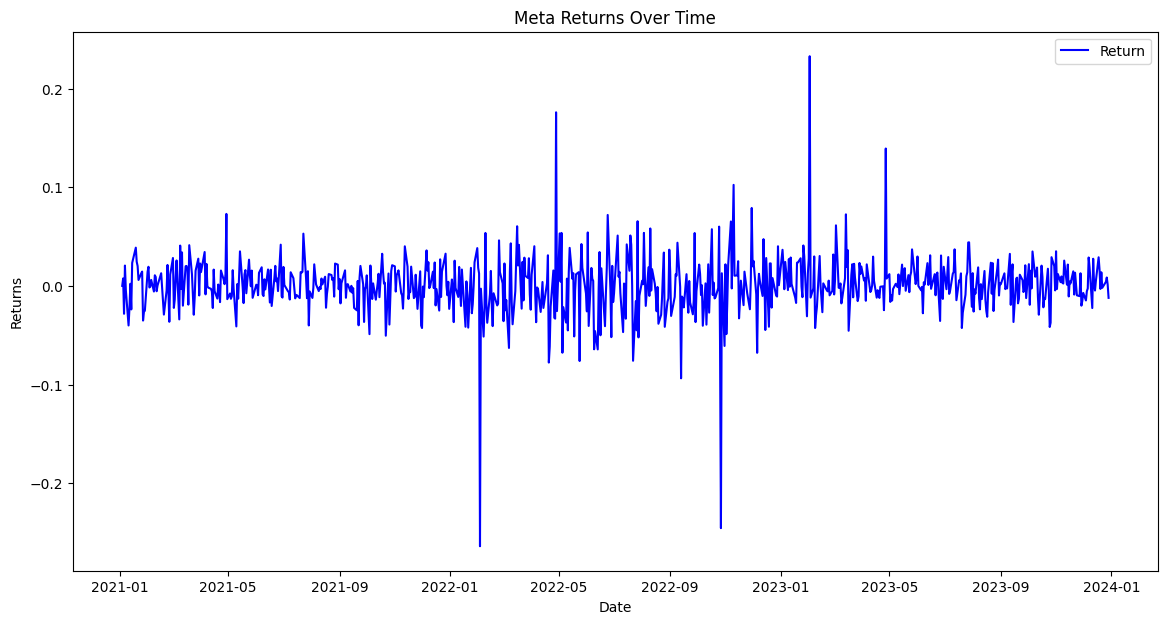

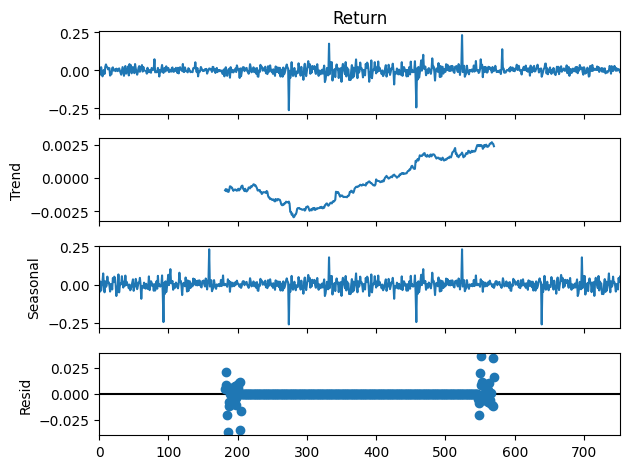

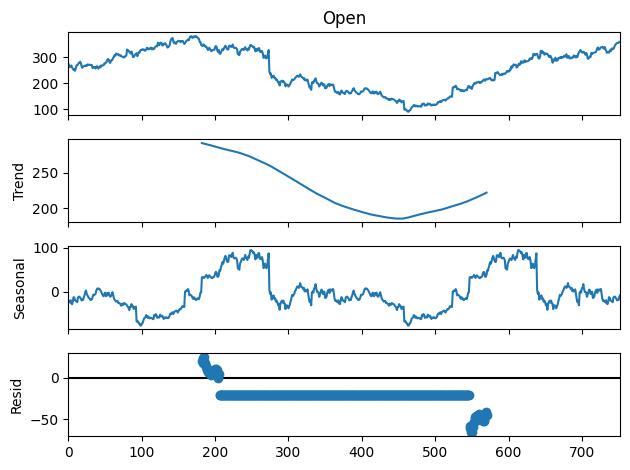

          Date    Open    High     Low   Close  Adj Close    Volume    Return
0   2023-12-21  352.98  356.41  349.21  354.09     353.03  15289600  0.013784
1   2023-12-22  355.58  357.20  351.22  353.39     352.33  11764200 -0.001983
2   2023-12-26  354.99  356.98  353.45  354.83     353.76   9898600  0.004059
3   2023-12-27  356.07  359.00  355.31  357.83     356.76  13207900  0.008480
4   2023-12-28  359.70  361.90  357.81  358.32     357.24  11798800  0.001345
..         ...     ...     ...     ...     ...        ...       ...       ...
157 2021-04-05  300.89  310.77  300.68  308.91     307.98  28237000  0.034323
158 2021-04-06  308.84  311.35  305.25  306.26     305.34  17335200 -0.008572
159 2021-04-07  306.34  314.25  305.50  313.09     312.15  22855200  0.022303
160 2021-04-08  314.85  315.88  310.05  313.02     312.08  20894100 -0.000224
161 2021-04-09  311.40  314.74  310.33  312.46     311.52  15988600 -0.001794

[162 rows x 8 columns]


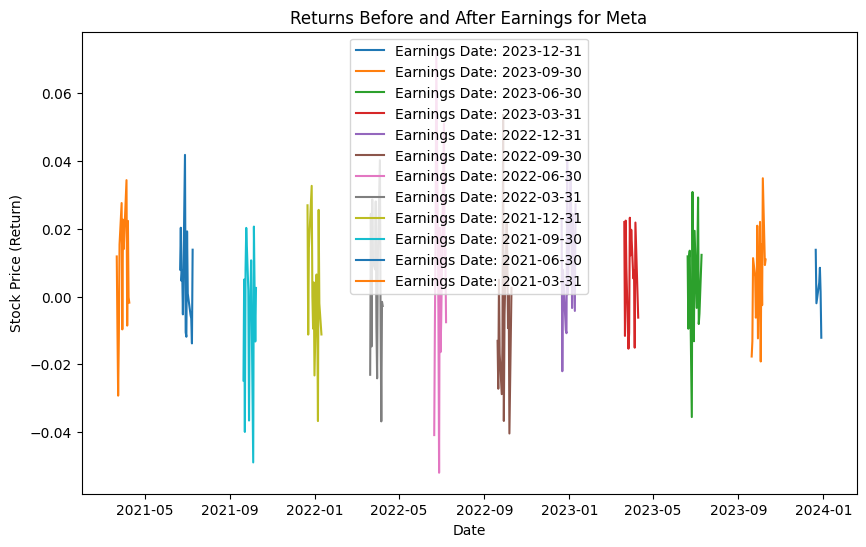

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data = pd.read_excel('/Users/Jestin/Desktop/Finance/Quant Finance/Meta/Meta 21_22_23.xlsx', sheet_name='Sheet1')

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Basic Summary
print("Data Summary:")
print(data.info())
print("\nData Description:")
print(data.describe())

# Remove extra space from columns
data.columns = data.columns.str.strip()

# Distribution of Adjusted Close Prices
plt.figure(figsize=(10, 5))
sns.histplot(data['Return'], bins=30, kde=True, color='blue')
plt.title('Distribution of Return')
plt.xlabel('Return')
plt.show()

# Distribution of Open Prices
plt.figure(figsize=(10, 5))
sns.histplot(data['Open'], bins=30, kde=True, color='blue')
plt.title('Distribution of Open Prices')  # Corrected title
plt.xlabel('Open Price')
plt.show()

# Volume vs Adjusted Close Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data['Volume'], y=data['Return'])
plt.title('Volume vs Adjusted Close Price')
plt.xlabel('Volume')
plt.ylabel('Return')
plt.show()

# Visualize stock price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Return'], label='Return', color='blue')
plt.title('Meta Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Checking for Seasonality and Trends
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose Return column (additive model)
decomposition_adj_close = seasonal_decompose(data['Return'], model='additive', period=365)
decomposition_adj_close.plot()
plt.show()

# Decompose Open column (additive model)
decomposition_open = seasonal_decompose(data['Open'], model='additive', period=365)
decomposition_open.plot()
plt.show()

# Earnings dates (ensure they fall within the data range)
earnings_dates = [
    '2023-12-31', '2023-09-30', '2023-06-30', '2023-03-31',
    '2022-12-31', '2022-09-30', '2022-06-30', '2022-03-31',
    '2021-12-31', '2021-09-30', '2021-06-30', '2021-03-31'
]

earnings_dates = pd.to_datetime(earnings_dates)

# Insert a number for 'window_before_after'

# Adj Close Price

# Extracting the data for windows around earnings announcements
window_before_after = 10 # 10 days before and after earnings
price_windows = []

for earnings_date in earnings_dates:
    start_date = earnings_date - pd.Timedelta(days=window_before_after)
    end_date = earnings_date + pd.Timedelta(days=window_before_after)
    
    # Extract the stock price data for this window, using 'Date' as the column name
    window_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    price_windows.append(window_data)

# Combine all the windows into one DataFrame
price_windows_df = pd.concat(price_windows)

# Optionally, reset index for cleaner DataFrame
price_windows_df = price_windows_df.reset_index(drop=True)

# Display the combined price window DataFrame
print(price_windows_df)

# Plot stock price before and after earnings
plt.figure(figsize=(10, 6))

for earnings_date in earnings_dates:
    window_data = price_windows_df[price_windows_df['Date'].between(earnings_date - pd.Timedelta(days=window_before_after),
                                                                     earnings_date + pd.Timedelta(days=window_before_after))]
    plt.plot(window_data['Date'], window_data['Return'], label=f'Earnings Date: {earnings_date.date()}')

plt.title('Returns Before and After Earnings for Meta')
plt.xlabel('Date')
plt.ylabel('Stock Price (Return)')
plt.legend()
plt.show()

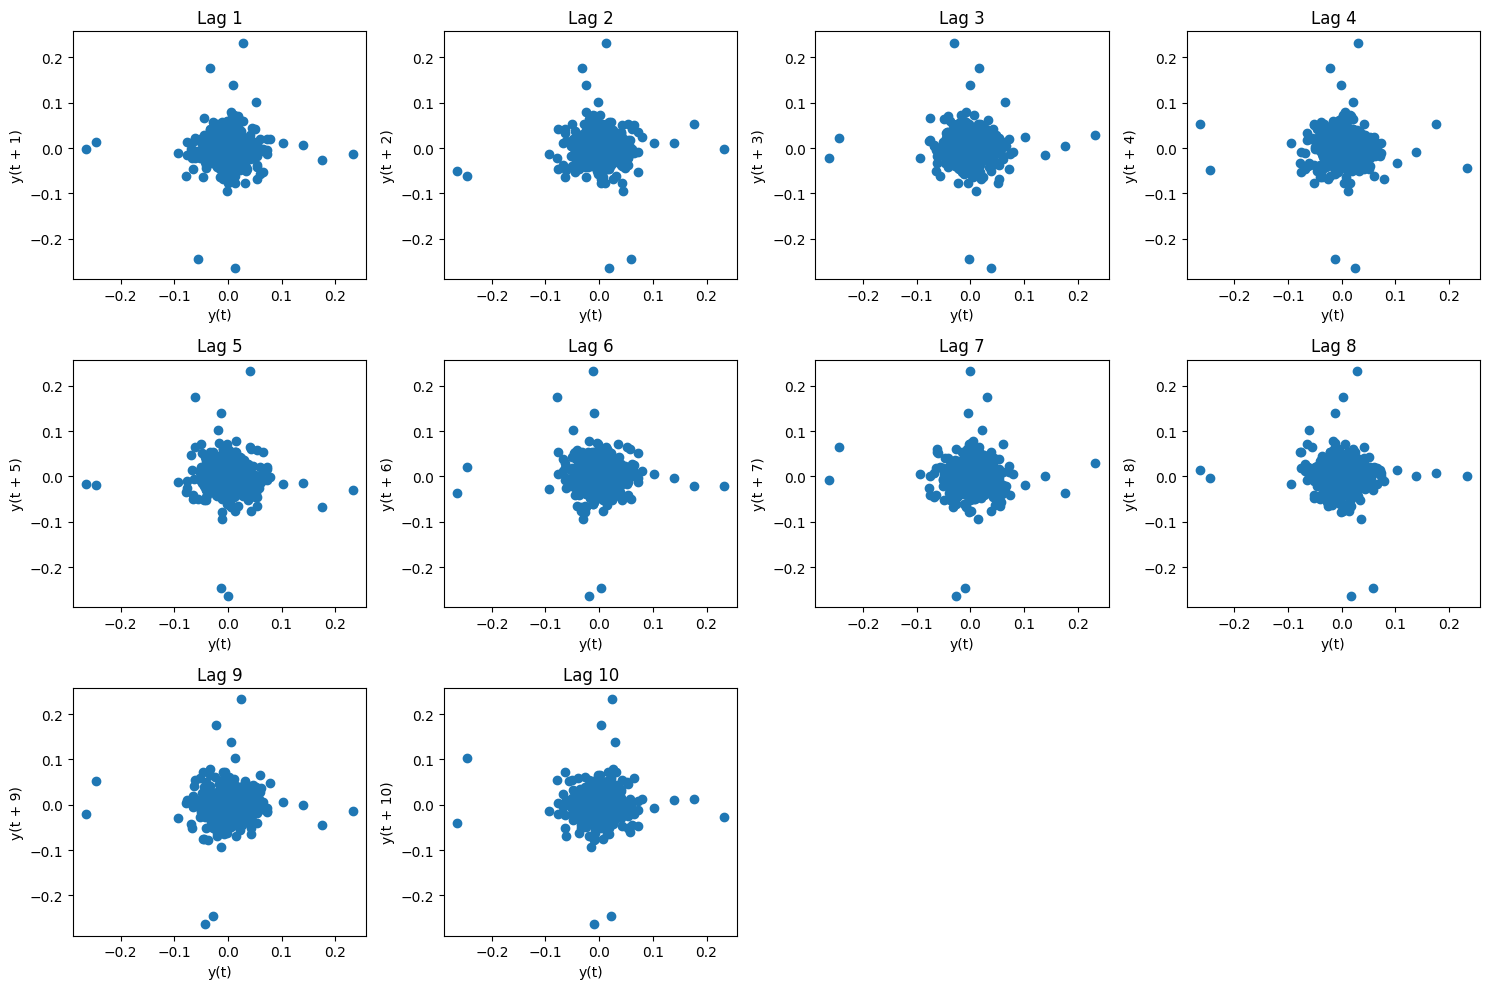

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

# Create lag plots
def plot_lag(data, lags=10):
    plt.figure(figsize=(15, 10))
    for i in range(1, lags + 1):
        plt.subplot(3, 4, i)  # Grid of subplots, adjust as needed
        lag_plot(data['Return'], lag=i)
        plt.title(f'Lag {i}')
    plt.tight_layout()
    plt.show()

# Plot lag plots for the Adjusted Close price column
plot_lag(data, lags=10)

<Figure size 1000x600 with 0 Axes>

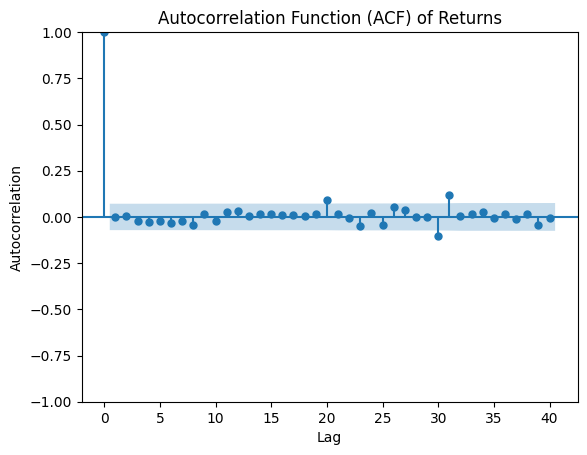

ADF Statistic: -27.378764345007337
p-value: 0.0


In [4]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot Autocorrelation
def plot_autocorrelation(data, lags=40):
    plt.figure(figsize=(10, 6))
    plot_acf(data['Return'], lags=lags)
    plt.title(f'Autocorrelation Function (ACF) of Returns')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

# Plot the autocorrelation for the Adjusted Close column with 40 lags
plot_autocorrelation(data, lags=40)

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Return'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [20]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['Return'].dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("Data is stationary.")
else:
    print("Data is not stationary. Differencing may be required.")

ADF Statistic: -27.378764345007337
p-value: 0.0
Data is stationary.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


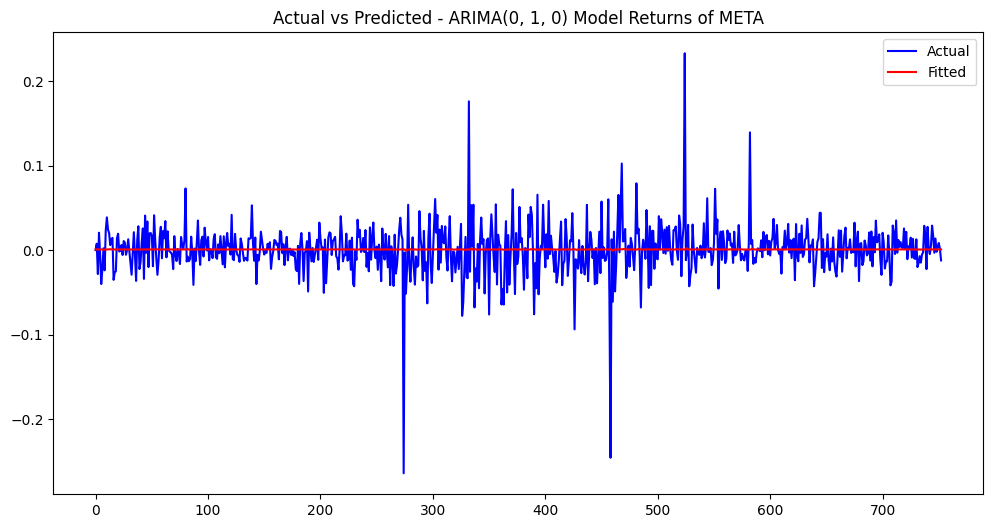

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  753
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1581.278
Date:                Sat, 16 Nov 2024   AIC                          -3150.557
Time:                        16:01:02   BIC                          -3122.812
Sample:                             0   HQIC                         -3139.868
                                - 753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.736      0.462      -0.001       0.003
ar.L1       7.644e-05      6.055   1.26e-05      1.000     -11.867      11.867
ar.L2          0.0032      4.496      0.001      0.9

In [28]:
# Fit ARIMA model on the differenced data
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'data' is your dataframe and 'Adj Close Diff' is the differenced column
arima_model = ARIMA(data['Return'].dropna(), order=(2, 0, 2))  # ARIMA(0, 1, 0)
arima_result = arima_model.fit()

# Get the predicted values from the ARIMA model
predicted_values = arima_result.fittedvalues

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Return'], label='Actual', color='blue')
plt.plot(predicted_values, label='Fitted', color='red')
plt.title('Actual vs Predicted - ARIMA(0, 1, 0) Model Returns of META')
plt.legend()
plt.show()

# Print model summary
print(arima_result.summary())


<Figure size 1200x600 with 0 Axes>

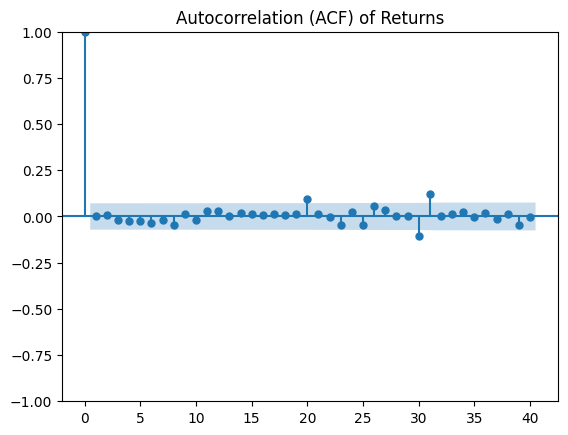

<Figure size 1200x600 with 0 Axes>

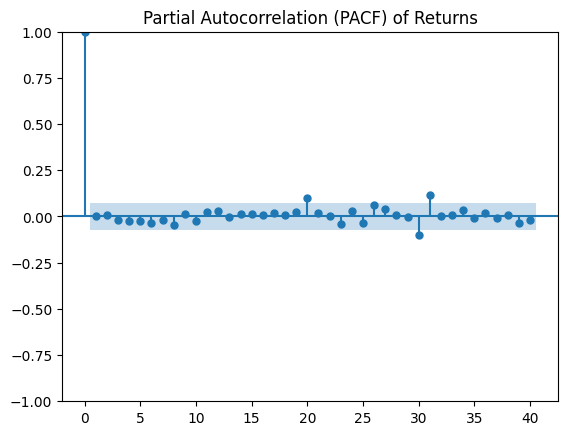

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming 'data' is your dataframe and 'Return' is the column with returns data
# Ensure that the data is differenced if needed and drop NaN values
returns = data['Return'].dropna()

# Plot the ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(returns, lags=40, title='Autocorrelation (ACF) of Returns')
plt.show()

# Plot the PACF (Partial Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_pacf(returns, lags=40, title='Partial Autocorrelation (PACF) of Returns', method='ywm')
plt.show()
